# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, sys, random, importlib
import sqlite3
from datetime import date, datetime, timedelta

/tmp/ipykernel_53871/2373834602.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
sns.set(style="whitegrid")

In [28]:
df = pd.read_csv("dataset.csv")
df.head()

,id,rfid_tag,checkin_time,checkout_time,note,date
0,203628,BA6379D,NaN,NaN,libur,2025-11-23
1,203629,BB39389D,NaN,NaN,libur,2025-11-23
2,203630,AB33A9D,NaN,NaN,libur,2025-11-23
3,203631,ABEA3B9D,NaN,NaN,libur,2025-11-23
4,203632,AB7A3C9D,NaN,NaN,libur,2025-11-23


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159534 entries, 0 to 159533
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159534 non-null  int64 
 1   rfid_tag       159534 non-null  object
 2   checkin_time   66293 non-null   object
 3   checkout_time  40519 non-null   object
 4   note           102503 non-null  object
 5   date           159534 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.3+ MB


In [30]:
df.isnull().sum()

id                    0
rfid_tag              0
checkin_time      93241
checkout_time    119015
note              57031
date                  0
dtype: int64

## DISTRIBUSI KELAS

In [32]:
# isi missing di kolom 'note' berdasarkan ada/tidaknya 'checkin_time'
mask_missing = df['note'].isna() | (df['note'].astype(str).str.strip() == '')

# jika checkin_time ada -> hadir, jika tidak ada -> alpa
df.loc[mask_missing & df['checkin_time'].notna(), 'note'] = 'hadir'
df.loc[mask_missing & df['checkin_time'].isna(), 'note'] = 'alpa'

# optional: cek hasil singkat
df['note'].value_counts(dropna=False).head()

note
hadir    57031
libur    47011
alpa     46231
telat     9261
Name: count, dtype: int64

/tmp/ipykernel_53871/3409208628.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='note', data=df, order=df['note'].value_counts().index, palette='viridis')


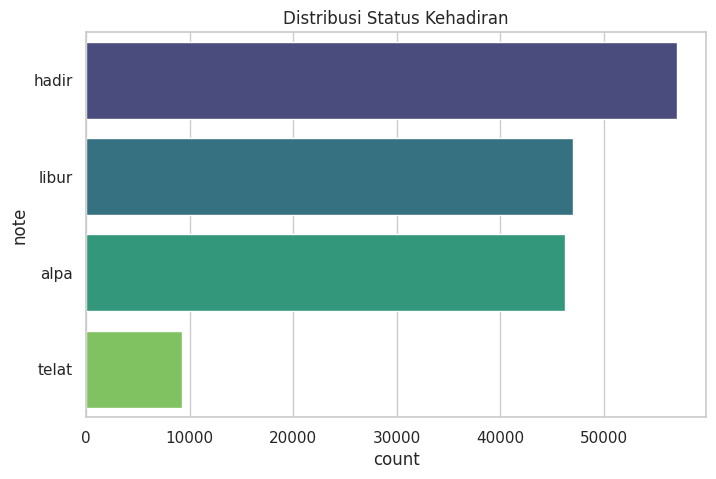

In [33]:
plt.figure(figsize=(8, 5))
sns.countplot(y='note', data=df, order=df['note'].value_counts().index, palette='viridis')
plt.title('Distribusi Status Kehadiran')
plt.show()

## ANALISIS WAKTU DATANG (Hanya data Hadir/Telat)

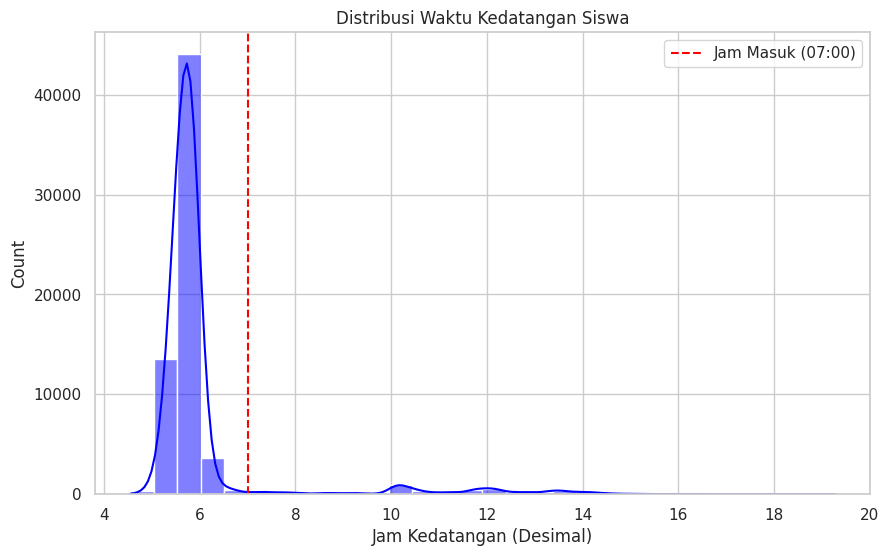

In [37]:
df_present = df.dropna(subset=['checkin_time']).copy()
df_present['checkin_time'] = pd.to_datetime(df_present['checkin_time'])
df_present['checkin_time'] = df_present['checkin_time'].dt.tz_convert('Asia/Jakarta')
df_present['arrival_hour'] = df_present['checkin_time'].dt.hour + df_present['checkin_time'].dt.minute/60

plt.figure(figsize=(10, 6))
sns.histplot(df_present['arrival_hour'], bins=30, kde=True, color='blue')
plt.axvline(x=7.0, color='red', linestyle='--', label='Jam Masuk (07:00)')
plt.title('Distribusi Waktu Kedatangan Siswa')
plt.xlabel('Jam Kedatangan (Desimal)')
plt.legend()
plt.show()


# FEATURE ENGINEERING

## Convert waktu checkin dan checkout ke WIB

In [40]:
def _to_wib_time(val):
    if pd.isna(val):
        return val
    try:
        # coba parse dengan asumsi ada keterangan timezone seperti 'GMT' -> dianggap UTC
        dt = pd.to_datetime(val, utc=True)
        # konversi ke timezone Asia/Jakarta (WIB)
        dt_wib = dt.tz_convert('Asia/Jakarta')
        return dt_wib.strftime('%H:%M:%S')
    except Exception:
        # fallback: parse tanpa tz, lalu tambahkan 7 jam
        try:
            dt = pd.to_datetime(val, errors='coerce')
            if pd.isna(dt):
                return val
            dt_wib = dt + pd.Timedelta(hours=7)
            return dt_wib.strftime('%H:%M:%S')
        except Exception:
            return val

In [42]:
df['checkin_time'] = df['checkin_time'].apply(_to_wib_time)
df['checkout_time'] = df['checkout_time'].apply(_to_wib_time)

## Tambah Kolom Day Of Week

In [41]:
def _to_day_of_week(val):
    if pd.isna(val):
        return val
    try:
        dt = pd.to_datetime(val, errors='coerce')
        if pd.isna(dt):
            return val
        return dt.day_name()
    except Exception:
        return val

In [43]:
# terapkan ke kolom 'date' tanpa mengubah missing values
df['DayOfWeek'] = df['date'].apply(_to_day_of_week)